In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.style
matplotlib.style.use("seaborn")
import matplotlib.pyplot as plt

import seaborn as sn
import scipy.stats as st
import math

from pingouin import rcorr



In [2]:
import sys
import os

from sys import platform
if platform == "darwin":
    sys.path.append(os.path.dirname(os.path.realpath(__file__)) + "/..")
    smart_nlp_path = ''
elif platform == "win32":
    sys.path.append('../')
    smart_nlp_path = os.getcwd()
    smart_nlp_path = "\\".join([smart_nlp_path.split("\\")[i] for i in range(0,len(smart_nlp_path.split("\\"))-1)]+["/"])

from module.trend_analysis_functions import *
from module.topic_model_plus_class import Topic_Model_plus

In [3]:
preprocessed_file = smart_nlp_path+r"\input data\ICS_filtered_preprocessed_combined_data.csv"
sitrep_df = pd.read_csv(preprocessed_file)
sitrep_df = sitrep_df.loc[sitrep_df["START_YEAR"]>2005].reset_index(drop=True)

incident_file = smart_nlp_path+r"input data\209-PLUS\ics209-plus-wildfire\ics209-plus-wildfire\ics209-plus-wf_incidents_1999to2014.csv"
incident_summary_df = pd.read_csv(incident_file)
incident_summary_df = incident_summary_df.drop("Unnamed: 0", axis=1)
incident_summary_df = incident_summary_df.loc[incident_summary_df["START_YEAR"]>=2006].reset_index(drop=True)

fire_ids = incident_summary_df['INCIDENT_ID'].unique()
sitrep_ids = sitrep_df['INCIDENT_ID'].unique()
sitrep_df = sitrep_df[sitrep_df['INCIDENT_ID'].isin(fire_ids)].reset_index(drop=True)
incident_summary_df =incident_summary_df[incident_summary_df['INCIDENT_ID'].isin(sitrep_ids)].reset_index(drop=True)
display(sitrep_df)
display(incident_summary_df)

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\srandrad\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (7,13,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,CY,DISCOVERY_DATE,INCIDENT_ID,PCT_CONTAINED_COMPLETED,START_YEAR,TOTAL_AERIAL,TOTAL_PERSONNEL,REPORT_DOY,DISCOVERY_DOY,Combined Text
0,2010,2010-07-15 15:00:00,2000_CA-RRU-062485_VALLEY COMPLEX,80.0,2010.0,5.000000,230.000000,197,196,"['resource', 'share', 'cactus']"
1,2010,2010-07-15 15:00:00,2000_CA-RRU-062485_VALLEY COMPLEX,60.0,2010.0,5.000000,230.000000,197,196,"['resource', 'share', 'incident', 'cactus', 'i..."
2,2010,2010-07-15 15:00:00,2000_CA-RRU-062485_VALLEY COMPLEX,30.0,2010.0,4.000000,165.000000,197,196,"['resource', 'share', 'cactus', 'erratic', 'pr..."
3,2010,2010-07-15 15:00:00,2000_CA-RRU-062485_VALLEY COMPLEX,30.0,2010.0,4.333333,192.333333,197,196,"['resource', 'share', 'cactus', 'cactus', 'bec..."
4,2010,2010-07-15 15:00:00,2000_CA-RRU-062485_VALLEY COMPLEX,100.0,2010.0,4.333333,192.333333,197,196,"['resource', 'share', 'cactus', 'cactus', 'bec..."
...,...,...,...,...,...,...,...,...,...,...
53292,2014,2014-03-21 13:00:00,2014_VAVAS1406043_PINE CREEK,100.0,2014.0,0.000000,14.000000,82,80,['fuel']
53293,2014,2014-03-21 13:00:00,2014_VAVAS1406043_PINE CREEK,100.0,2014.0,0.000000,14.000000,82,80,['fuel']
53294,2014,2014-08-20 13:00:00,2014_WA-WFS-513_SAND RIDGE,0.0,2014.0,1.000000,95.000000,234,232,"['heavy', 'canyon', 'river', 'mainly', 'canyon..."
53295,2014,2014-08-20 13:00:00,2014_WA-WFS-513_SAND RIDGE,86.0,2014.0,1.000000,120.000000,235,232,"['laid', 'night', 'test', 'remain', 'canyon', ..."


,INCIDENT_ID,INCIDENT_NUMBER,INCIDENT_NAME,INCTYP_ABBREVIATION,FINAL_ACRES,CAUSE,COMPLEX,DISCOVERY_DATE,DISCOVERY_DOY,EXPECTED_CONTAINMENT_DATE,...,FOD_CAUSE_DESCR,FOD_FIRE_SIZE,FOD_COMPLEX_NAME,FOD_OBJ,FOD_LIST,FOD_ID,MTBS_ID,MTBS_FIRE_NAME,FOD_LATITUDE,FOD_LONGITUDE
0,2000_CA-RRU-062485_VALLEY COMPLEX,CA-RRU-062485,VALLEY COMPLEX,WF,1312.0,L,True,2010-07-15 15:00:00,196,2010-07-18 00:00:00,...,Lightning,1289.0,VALLEY COMPLEX,"[{""ID"" : 1386075, ""COORDS"" : (33.63888888, -11...","['{""ID"" : 1386075, ""COORDS"" : (33.63888888, -1...",1432504.0,(VALLEY COMPLEX),NaN,34.066667,-87.189444
1,2005_OK-CHA-005077_WILLIS,OK-CHA-005077,WILLIS,WF,460.0,H,False,2005-12-30 00:00:00,1,2006-01-05 16:00:00,...,['Arson' 'Missing/Undefined'],920.0,NaN,"[{""ID"" : 251856, ""COORDS"" : (33.8833, -96.8169...","['{""ID"" : 251856, ""COORDS"" : (33.8833, -96.816...",251856.0,NaN,NaN,34.066667,-87.189444
2,2006_00276_MILLER COMPLEX,00276,MILLER COMPLEX,WF,300.0,L,True,2006-06-26 19:55:00,177,2006-07-03 18:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2006_1224_MULTIPLE JUNE FIRES,1224,MULTIPLE JUNE FIRES,WF,21.0,L,False,2006-06-26 15:00:00,177,2006-07-01 18:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2006_AK-DAS-612166_JARVIS CREEK,AK-DAS-612166,JARVIS CREEK,WF,275.0,H,False,2006-06-08 11:13:00,159,2006-06-13 23:59:00,...,Miscellaneous,275.0,NaN,"[{""ID"" : 311918, ""COORDS"" : (63.8667, -145.75)...","['{""ID"" : 311918, ""COORDS"" : (63.8667, -145.75...",311918.0,NaN,NaN,63.866700,-145.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9866,2014_VAVAS1406037_AIRPORT MOUNTAIN,VAVAS1406037,Airport Mountain,WF,200.0,H,False,2014-03-19 14:00:00,78,NaN,...,Arson,375.0,NaN,"[{""ID"" : 300117756, ""COORDS"" : (37.24325, -82....","['{""ID"" : 300117756, ""COORDS"" : (37.24325, -82...",300117756.0,NaN,NaN,37.243250,-82.103528
9867,2014_VAVAS1406040_BAKERS RIDGE,VAVAS1406040,Bakers Ridge,WF,100.0,H,False,2014-03-22 12:00:00,81,NaN,...,Equipment Use,100.0,NaN,"[{""ID"" : 300083746, ""COORDS"" : (36.87027778, -...","['{""ID"" : 300083746, ""COORDS"" : (36.87027778, ...",300083746.0,NaN,NaN,36.870278,-82.286333
9868,2014_VAVAS1406041_NEIGHBOR TRAIL,VAVAS1406041,Neighbor Trail,WF,180.0,H,False,2014-03-21 12:00:00,80,NaN,...,Miscellaneous,120.0,NaN,"[{""ID"" : 300144282, ""COORDS"" : (36.71777778, -...","['{""ID"" : 300144282, ""COORDS"" : (36.71777778, ...",300144282.0,NaN,NaN,36.717778,-82.843333
9869,2014_VAVAS1406043_PINE CREEK,VAVAS1406043,Pine Creek,WF,150.0,H,False,2014-03-21 13:00:00,80,NaN,...,Missing/Undefined,150.0,NaN,"[{""ID"" : 300150138, ""COORDS"" : (37.0841667, -8...","['{""ID"" : 300150138, ""COORDS"" : (37.0841667, -...",300150138.0,NaN,NaN,37.084167,-81.910833


## FIRE TREND ANALYSIS
examining trends in frequency, acres burned, and the number of days a fire burns on average per year. Potentially add FSR (WF_MAX_FSR), number of complexes (COMPLEX), evacuations (EVACUATION_REPORTED)


In [4]:
fire_trends_cols = ["FINAL_ACRES", "FOD_DISCOVERY_DOY", "FOD_CONTAIN_DOY", "START_YEAR"]
fire_trends_df = incident_summary_df[fire_trends_cols]
fire_trends_df 

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,FINAL_ACRES,FOD_DISCOVERY_DOY,FOD_CONTAIN_DOY,START_YEAR
0,1312.0,196.0,197.0,2010.0
1,460.0,1.0,5.0,2006.0
2,300.0,NaN,NaN,2006.0
3,21.0,NaN,NaN,2006.0
4,275.0,159.0,167.0,2006.0
...,...,...,...,...
9866,200.0,78.0,NaN,2014.0
9867,100.0,80.0,NaN,2014.0
9868,180.0,80.0,NaN,2014.0
9869,150.0,80.0,NaN,2014.0


In [5]:
counts = fire_trends_df["START_YEAR"].value_counts()
counts

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2006.0    1689
2011.0    1560
2007.0    1218
2008.0    1214
2012.0    1101
2010.0     917
2014.0     877
2009.0     661
2013.0     634
Name: START_YEAR, dtype: int64

In [6]:
type(counts)

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


pandas.core.series.Series

In [7]:
years = []
count = []
for key in counts.index:
    years.append(key)
years.sort()
count = [counts[year] for year in years]

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


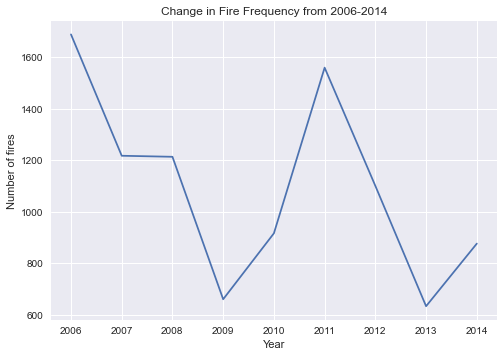

In [8]:
plt.figure()
plt.ylabel("Number of fires")
plt.xlabel("Year")
plt.title("Change in Fire Frequency from 2006-2014")
plt.plot(years, count)
plt.show()

While the above plot does not show a consistent linear trend, these results are consistent with the findings of the authors of the original papers

In [9]:
years =  fire_trends_df["START_YEAR"].unique()
years.sort()

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
years

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([2006., 2007., 2008., 2009., 2010., 2011., 2012., 2013., 2014.])

In [11]:
average_days_burning = {}
total_days_burning = {}
for year in years:
    list_of_days_burning = []
    temp_df = fire_trends_df.loc[fire_trends_df['START_YEAR']==year]
    for i in range(len(temp_df)):
        start_day = temp_df.iloc[i]['FOD_DISCOVERY_DOY']
        end_day = temp_df.iloc[i]["FOD_CONTAIN_DOY"]
        if not pd.isna(start_day) and not pd.isna(end_day):
            days_burn = end_day - start_day
            list_of_days_burning.append(days_burn)
    average_days_burning[year] = np.average(list_of_days_burning)
    total_days_burning[year] = np.sum(list_of_days_burning)
print(total_days_burning)

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{2006.0: 10837.0, 2007.0: 9900.0, 2008.0: 8005.0, 2009.0: 9802.0, 2010.0: 10083.0, 2011.0: 12874.0, 2012.0: 12824.0, 2013.0: 10967.0, 2014.0: 10272.0}


C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


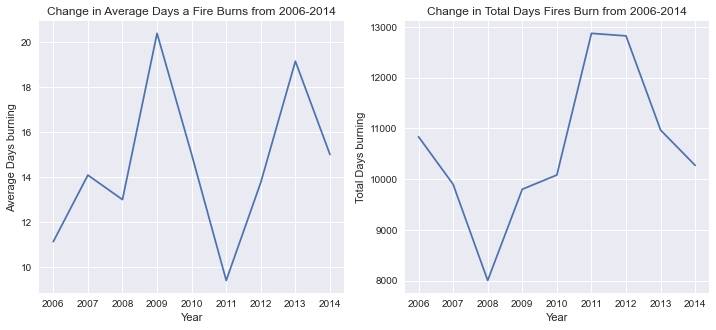

In [12]:
av_days_burn = [average_days_burning[key] for key in average_days_burning]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.ylabel("Average Days burning")
plt.xlabel("Year")
plt.title("Change in Average Days a Fire Burns from 2006-2014")
plt.plot(years, av_days_burn)

total_days_burn = [total_days_burning[key] for key in total_days_burning]
plt.subplot(1,2,2)
plt.ylabel("Total Days burning")
plt.xlabel("Year")
plt.title("Change in Total Days Fires Burn from 2006-2014")
plt.plot(years, total_days_burn)
plt.show()
plt.close()


In [13]:
total_acres = {}
average_acres = {}
for year in years:
    list_of_acres = []
    temp_df = fire_trends_df.loc[fire_trends_df['START_YEAR']==year]
    for i in range(len(temp_df)):
        acres = temp_df.iloc[i]['FINAL_ACRES']
        if not pd.isna(acres):
            list_of_acres.append(acres)
    average_acres[year] = np.average(list_of_acres)
    total_acres[year] = np.sum(list_of_acres)

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


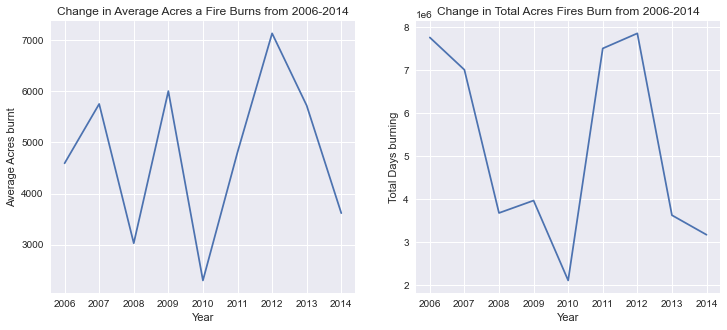

In [14]:
av_acres = [average_acres[key] for key in average_acres]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.ylabel("Average Acres burnt")
plt.xlabel("Year")
plt.title("Change in Average Acres a Fire Burns from 2006-2014")
plt.plot(years, av_acres)

total_acre = [total_acres[key] for key in total_acres]
plt.subplot(1,2,2)
plt.ylabel("Total Days burning")
plt.xlabel("Year")
plt.title("Change in Total Acres Fires Burn from 2006-2014")
plt.plot(years, total_acre)
plt.show()
plt.close()


## Testing Minmax scaling

Minmax scaling is used to maintain the data shape and trend, while scaling it to a size that is consistent accross inputs. This is useful for showing graphs with multiple lines of different values, this way you can see and compare the overall trends without losing much information. Data must be scaled before being used as an input for any model, so for our multiple regression we will use scaled data.

As we can see, the scaled graphs below look the same as the unscaled graphs above, with the only difference being the y-axis values.

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


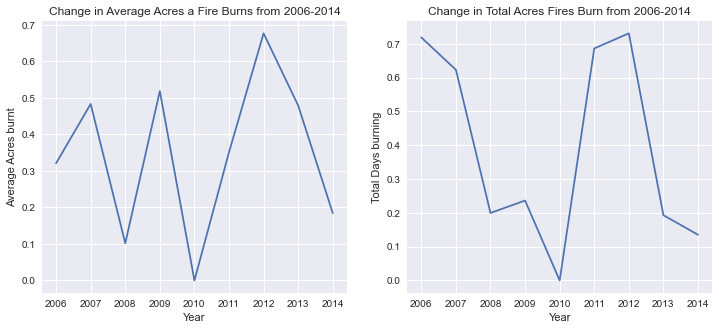

In [15]:
av_acres = [average_acres[key] for key in average_acres]
av_acres_scaled = minmax_scale(av_acres)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.ylabel("Average Acres burnt")
plt.xlabel("Year")
plt.title("Change in Average Acres a Fire Burns from 2006-2014")
plt.plot(years, av_acres_scaled)

total_acre = [total_acres[key] for key in total_acres]
total_acres_scaled = minmax_scale(total_acre)
plt.subplot(1,2,2)
plt.ylabel("Total Days burning")
plt.xlabel("Year")
plt.title("Change in Total Acres Fires Burn from 2006-2014")
plt.plot(years, total_acres_scaled)
plt.show()
plt.close()

#### Graphs

In [16]:
freq_scaled = minmax_scale(count)
av_days_burn_scaled = minmax_scale(av_days_burn)
av_acres_scaled = minmax_scale(av_acres)

total_days_burn_scaled = minmax_scale(total_days_burn)
total_acres_scaled = minmax_scale(total_acre)

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


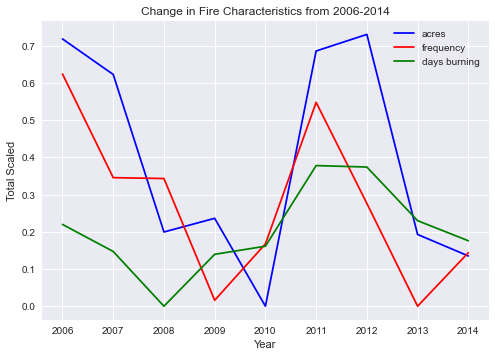

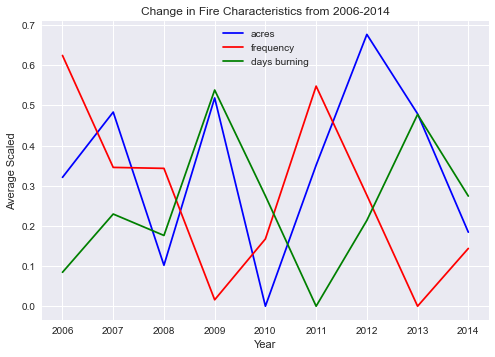

In [17]:
#plt.figure(figsize=(12, 5))
#plt.subplot(1, 2, 1)
plt.figure()
plt.ylabel("Total Scaled")
plt.xlabel("Year")
plt.title("Change in Fire Characteristics from 2006-2014")
plt.plot(years, total_acres_scaled, color="blue", label="acres")
plt.plot(years, freq_scaled, color="red", label="frequency")
plt.plot(years, total_days_burn_scaled, color="green", label="days burning")
plt.legend()
plt.show()

#plt.subplot(1, 2, 2)
plt.figure()
plt.ylabel("Average Scaled")
plt.xlabel("Year")
plt.title("Change in Fire Characteristics from 2006-2014")
plt.plot(years, av_acres_scaled, color="blue", label="acres")
plt.plot(years, freq_scaled, color="red", label="frequency")
plt.plot(years, av_days_burn_scaled, color="green", label="days burning")
plt.legend()
plt.show()
plt.close()

## OPERATIONAL TRENDS ANALYSIS

operational trends are examined as aerial assets (total and max in one day), personnel (total and max in one day), and projected cost.
potentially add number of sit reports (INC_MGMT_NUM_SITREPS)??

In [18]:
operational_trends_cols = ["TOTAL_AERIAL_SUM", "TOTAL_PERSONNEL_SUM", "WF_PEAK_AERIAL", "WF_PEAK_PERSONNEL", "START_YEAR","PROJECTED_FINAL_IM_COST"]
operational_trends_df = incident_summary_df[operational_trends_cols]
operational_trends_df 

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,TOTAL_AERIAL_SUM,TOTAL_PERSONNEL_SUM,WF_PEAK_AERIAL,WF_PEAK_PERSONNEL,START_YEAR,PROJECTED_FINAL_IM_COST
0,29.0,2798.000000,5.0,569.000000,2010.0,2024373.0
1,NaN,42.000000,NaN,42.000000,2006.0,20000.0
2,1.0,2578.000000,1.0,345.000000,2006.0,1333486.0
3,7.0,1248.000000,2.0,247.000000,2006.0,300000.0
4,5.0,712.000000,3.0,112.000000,2006.0,366482.0
...,...,...,...,...,...,...
9866,NaN,55.500000,NaN,18.500000,2014.0,5200.0
9867,NaN,12.000000,NaN,12.000000,2014.0,500.0
9868,2.0,138.666667,1.0,69.333333,2014.0,2800.0
9869,NaN,56.000000,NaN,14.000000,2014.0,1600.0


In [19]:
operational_trends_df = operational_trends_df.loc[operational_trends_df["TOTAL_PERSONNEL_SUM"].notna()]
#remove rows with no personnel bc all fires would have some personnel, indicates incomplete reporting
operational_trends_df

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,TOTAL_AERIAL_SUM,TOTAL_PERSONNEL_SUM,WF_PEAK_AERIAL,WF_PEAK_PERSONNEL,START_YEAR,PROJECTED_FINAL_IM_COST
0,29.0,2798.000000,5.0,569.000000,2010.0,2024373.0
1,NaN,42.000000,NaN,42.000000,2006.0,20000.0
2,1.0,2578.000000,1.0,345.000000,2006.0,1333486.0
3,7.0,1248.000000,2.0,247.000000,2006.0,300000.0
4,5.0,712.000000,3.0,112.000000,2006.0,366482.0
...,...,...,...,...,...,...
9866,NaN,55.500000,NaN,18.500000,2014.0,5200.0
9867,NaN,12.000000,NaN,12.000000,2014.0,500.0
9868,2.0,138.666667,1.0,69.333333,2014.0,2800.0
9869,NaN,56.000000,NaN,14.000000,2014.0,1600.0


In [20]:
total_aerial = {}
average_aerial = {}
total_person = {}
average_person = {}
for year in years:
    list_of_person = []
    list_of_aerial = []
    temp_df = operational_trends_df.loc[operational_trends_df['START_YEAR']==year]
    for i in range(len(temp_df)):
        aerial = temp_df.iloc[i]["WF_PEAK_AERIAL"]
        person = temp_df.iloc[i]['WF_PEAK_PERSONNEL']
        list_of_person.append(person)
        if pd.isna(aerial):
            aerial = 0
        list_of_aerial.append(aerial)
    average_aerial[year] = np.average(list_of_aerial)
    total_aerial[year] = np.sum(list_of_aerial)
    average_person[year] = np.average(list_of_person)
    total_person[year] = np.sum(list_of_person)

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


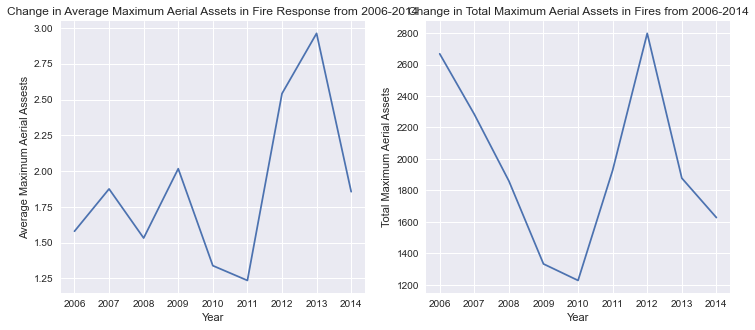

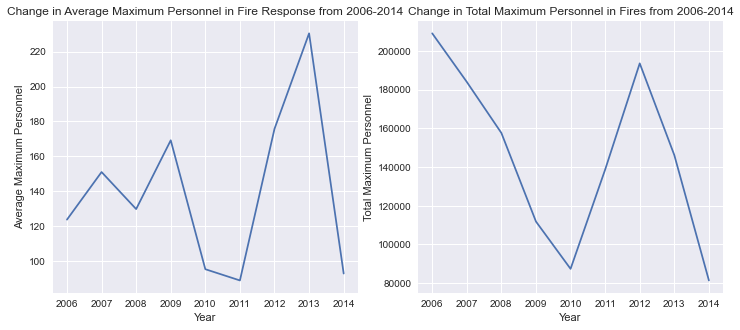

In [21]:
av_aerial = [average_aerial[key] for key in average_aerial]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.ylabel("Average Maximum Aerial Assests")
plt.xlabel("Year")
plt.title("Change in Average Maximum Aerial Assets in Fire Response from 2006-2014")
plt.plot(years, av_aerial)

total_aerial = [total_aerial[key] for key in total_aerial]
plt.subplot(1,2,2)
plt.ylabel("Total Maximum Aerial Assets")
plt.xlabel("Year")
plt.title("Change in Total Maximum Aerial Assets in Fires from 2006-2014")
plt.plot(years, total_aerial)
plt.show()
plt.close()

av_person = [average_person[key] for key in average_person]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.ylabel("Average Maximum Personnel")
plt.xlabel("Year")
plt.title("Change in Average Maximum Personnel in Fire Response from 2006-2014")
plt.plot(years, av_person)

total_person = [total_person[key] for key in total_person]
plt.subplot(1,2,2)
plt.ylabel("Total Maximum Personnel")
plt.xlabel("Year")
plt.title("Change in Total Maximum Personnel in Fires from 2006-2014")
plt.plot(years, total_person)
plt.show()
plt.close()


In [22]:
total_cost = {}
average_cost = {}
for year in years:
    list_of_cost = []
    temp_df = operational_trends_df.loc[operational_trends_df['START_YEAR']==year]
    for i in range(len(temp_df)):
        cost = temp_df.iloc[i]["PROJECTED_FINAL_IM_COST"]
        if not pd.isna(cost):
            list_of_cost.append(cost)
    average_cost[year] = np.average(list_of_cost)
    total_cost[year] = np.sum(list_of_cost)

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


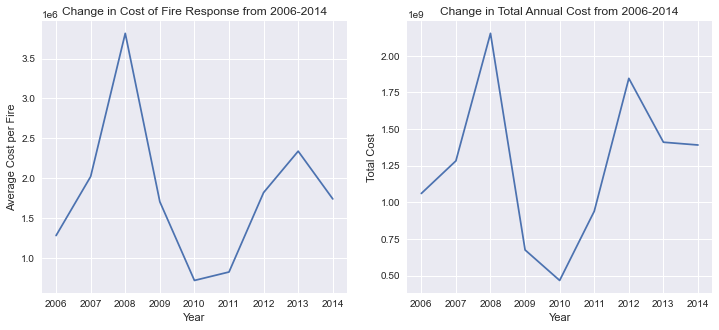

In [23]:
av_cost = [average_cost[key] for key in average_cost]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.ylabel("Average Cost per Fire")
plt.xlabel("Year")
plt.title("Change in Cost of Fire Response from 2006-2014")
plt.plot(years, av_cost)

total_cost = [total_cost[key] for key in total_cost]
plt.subplot(1,2,2)
plt.ylabel("Total Cost")
plt.xlabel("Year")
plt.title("Change in Total Annual Cost from 2006-2014")
plt.plot(years, total_cost)
plt.show()
plt.close()


#### Graphs

In [24]:
av_cost_scaled = minmax_scale(av_cost)
av_person_scaled = minmax_scale(av_person)
av_aerial_scaled = minmax_scale(av_aerial)

total_cost_scaled = minmax_scale(total_cost)
total_person_scaled = minmax_scale(total_person)
total_aerial_scaled = minmax_scale(total_aerial)

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


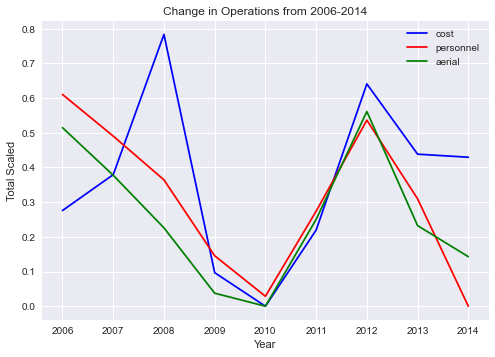

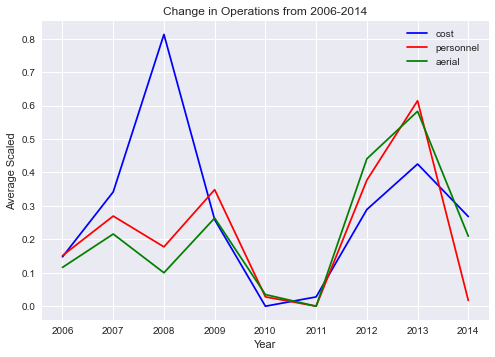

In [25]:
#plt.figure(figsize=(12, 5))
#plt.subplot(1, 2, 1)
plt.figure()
plt.ylabel("Total Scaled")
plt.xlabel("Year")
plt.title("Change in Operations from 2006-2014")
plt.plot(years, total_cost_scaled, color="blue", label="cost")
plt.plot(years, total_person_scaled, color="red", label="personnel")
plt.plot(years, total_aerial_scaled, color="green", label="aerial")
plt.legend()
plt.show()

#plt.subplot(1, 2, 2)
plt.figure()
plt.ylabel("Average Scaled")
plt.xlabel("Year")
plt.title("Change in Operations from 2006-2014")
plt.plot(years, av_cost_scaled, color="blue", label="cost")
plt.plot(years, av_person_scaled, color="red", label="personnel")
plt.plot(years, av_aerial_scaled, color="green", label="aerial")
plt.legend()
plt.show()
plt.close()

## INTENSITY TREND ANALYSIS
intensity is looked at as the number of injuries, number of fatalities, number of structures damaged, number of structures destroyed

In [26]:
intensity_cols = ["STR_DESTROYED_TOTAL","STR_DAMAGED_TOTAL","INJURIES_TOTAL","FATALITIES", "START_YEAR"]
intensity_df = incident_summary_df[intensity_cols]
intensity_df

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,STR_DESTROYED_TOTAL,STR_DAMAGED_TOTAL,INJURIES_TOTAL,FATALITIES,START_YEAR
0,0.0,0.0,1.0,0.0,2010.0
1,0.0,0.0,1.0,0.0,2006.0
2,0.0,0.0,0.0,0.0,2006.0
3,0.0,0.0,0.0,0.0,2006.0
4,0.0,0.0,0.0,0.0,2006.0
...,...,...,...,...,...
9866,0.0,0.0,0.0,0.0,2014.0
9867,0.0,0.0,0.0,0.0,2014.0
9868,0.0,0.0,0.0,0.0,2014.0
9869,0.0,0.0,0.0,0.0,2014.0


In [27]:
total_str_des = {}
average_str_des = {}
total_str_damage = {}
average_str_damage = {}
total_injuries = {}
average_injuries = {}
total_fatalities = {}
average_fatalities = {}

for year in years:
    list_of_dest = []
    list_of_dam = []
    list_of_injury = []
    list_of_fatalities = []
    temp_df =intensity_df.loc[intensity_df['START_YEAR']==year]
    for i in range(len(temp_df)):
        dest = temp_df.iloc[i]["STR_DESTROYED_TOTAL"]
        damage = temp_df.iloc[i]["STR_DAMAGED_TOTAL"]
        injury = temp_df.iloc[i]["INJURIES_TOTAL"]
        fatality = temp_df.iloc[i]["FATALITIES"]
        list_of_dest.append(dest)
        list_of_dam.append(damage)
        list_of_injury.append(injury)
        list_of_fatalities.append(fatality)
    total_str_des[year] = np.sum(list_of_dest)
    average_str_des[year] = np.average(list_of_dest)
    total_str_damage[year] = np.sum(list_of_dam)
    average_str_damage[year] = np.average(list_of_dam)
    total_injuries[year] = np.sum(list_of_injury)
    average_injuries[year] = np.average(list_of_injury)
    total_fatalities[year] = np.sum(list_of_fatalities)
    average_fatalities[year] = np.average(list_of_fatalities)

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


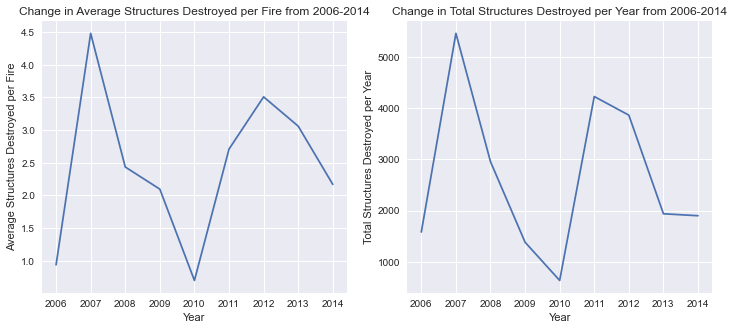

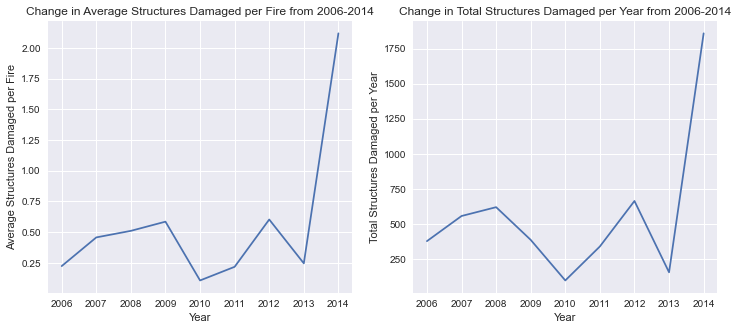

In [28]:
av_des = [average_str_des[key] for key in average_str_des]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.ylabel("Average Structures Destroyed per Fire")
plt.xlabel("Year")
plt.title("Change in Average Structures Destroyed per Fire from 2006-2014")
plt.plot(years, av_des)

total_des = [total_str_des[key] for key in total_str_des]
plt.subplot(1,2,2)
plt.ylabel("Total Structures Destroyed per Year")
plt.xlabel("Year")
plt.title("Change in Total Structures Destroyed per Year from 2006-2014")
plt.plot(years, total_des)
plt.show()
plt.close()

av_damage = [average_str_damage[key] for key in average_str_damage]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.ylabel("Average Structures Damaged per Fire")
plt.xlabel("Year")
plt.title("Change in Average Structures Damaged per Fire from 2006-2014")
plt.plot(years, av_damage)

total_damage = [total_str_damage[key] for key in total_str_damage]
plt.subplot(1,2,2)
plt.ylabel("Total Structures Damaged per Year")
plt.xlabel("Year")
plt.title("Change in Total Structures Damaged per Year from 2006-2014")
plt.plot(years, total_damage)
plt.show()
plt.close()


C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


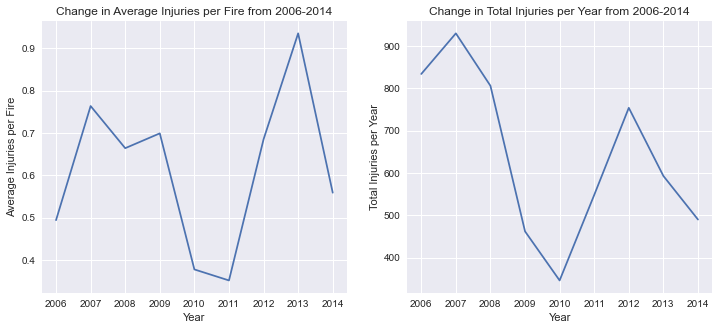

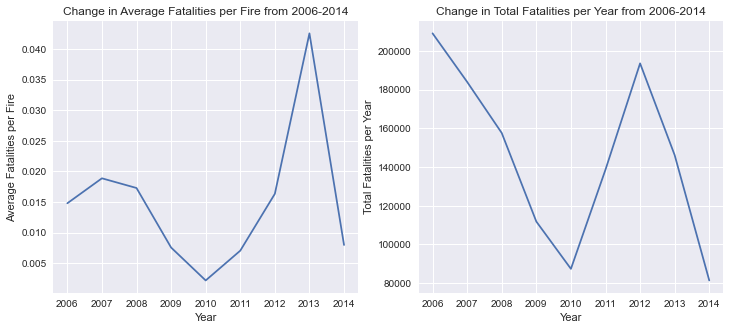

In [29]:
av_injury = [average_injuries[key] for key in average_injuries]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.ylabel("Average Injuries per Fire")
plt.xlabel("Year")
plt.title("Change in Average Injuries per Fire from 2006-2014")
plt.plot(years, av_injury)

total_injury = [total_injuries[key] for key in total_injuries]
plt.subplot(1,2,2)
plt.ylabel("Total Injuries per Year")
plt.xlabel("Year")
plt.title("Change in Total Injuries per Year from 2006-2014")
plt.plot(years, total_injury)
plt.show()
plt.close()

av_fatality = [average_fatalities[key] for key in average_fatalities]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.ylabel("Average Fatalities per Fire")
plt.xlabel("Year")
plt.title("Change in Average Fatalities per Fire from 2006-2014")
plt.plot(years, av_fatality)

total_fatality = [total_fatalities[key] for key in total_fatalities]
plt.subplot(1,2,2)
plt.ylabel("Total Fatalities per Year")
plt.xlabel("Year")
plt.title("Change in Total Fatalities per Year from 2006-2014")
plt.plot(years, total_person)
plt.show()
plt.close()


#### Graphs

In [30]:
total_fatality_scaled = minmax_scale(total_fatality)
total_injury_scaled = minmax_scale(total_injury)
total_damage_scaled = minmax_scale(total_damage)
total_des_scaled = minmax_scale(total_des)

av_fatality_scaled = minmax_scale(av_fatality)
av_injury_scaled = minmax_scale(av_injury)
av_damage_scaled = minmax_scale(av_damage)
av_des_scaled = minmax_scale(av_des)

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


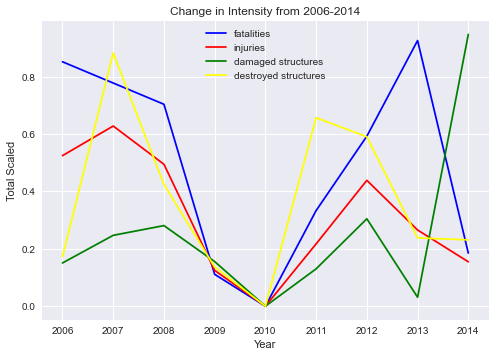

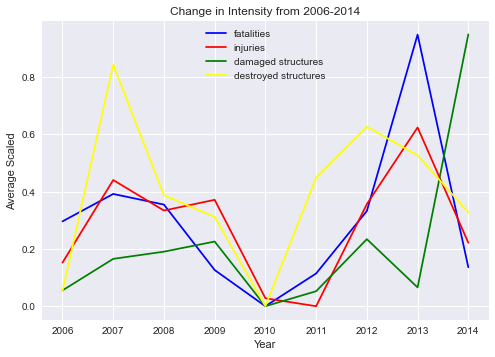

In [31]:
plt.figure()#(figsize=(12, 5))
#plt.subplot(1, 2, 1)
plt.ylabel("Total Scaled")
plt.xlabel("Year")
plt.title("Change in Intensity from 2006-2014")
plt.plot(years, total_fatality_scaled, color="blue", label="fatalities")
plt.plot(years, total_injury_scaled, color="red", label="injuries")
plt.plot(years, total_damage_scaled, color="green", label="damaged structures")
plt.plot(years, total_des_scaled, color="yellow", label="destroyed structures")
plt.legend()
plt.show()

#plt.subplot(1, 2, 2)
plt.figure()
plt.ylabel("Average Scaled")
plt.xlabel("Year")
plt.title("Change in Intensity from 2006-2014")
plt.plot(years, av_fatality_scaled, color="blue", label="fatalities")
plt.plot(years, av_injury_scaled, color="red", label="injuries")
plt.plot(years, av_damage_scaled, color="green", label="damaged structures")
plt.plot(years, av_des_scaled, color="yellow", label="destroyed structures")
plt.legend()
plt.show()
plt.close()

## Correlation Matrix

In [32]:
avs_df = pd.DataFrame({
    "fire frequency": count,
    "average days fire burns": av_days_burn,
    "average acres fire burns": av_acres,
    "average aerial assets per fire": av_aerial,
    "average personnel per fire": av_person,
    "average cost per fire": av_cost,
    "average structures damaged per fire": av_damage,
    "average structures destroyed per fire": av_des,
    "average injuries per fire": av_injury,
    "average fatalities per fire": av_fatality
})

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


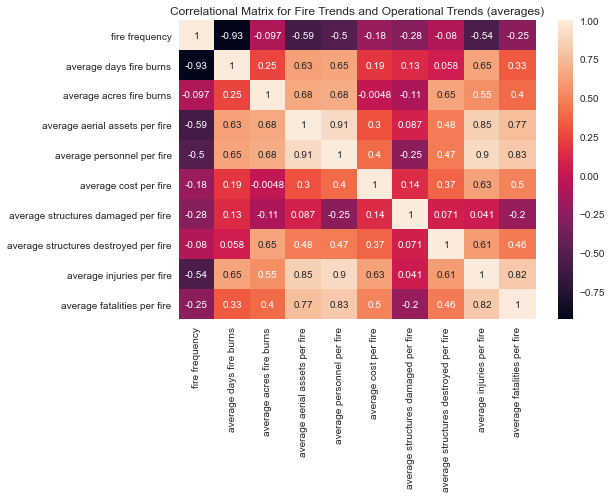

In [33]:
corrMatrix = avs_df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.title("Correlational Matrix for Fire Trends and Operational Trends (averages)")
plt.show()

As seen above, fire frequency is negatively correlated with assets, indicating higher frequencies may be smaller fires, where lower frequencies are related to larger fires, thus more assets. 

The average days the fire burns is weakly correlated with max assets, would likely be closer correlated with total assets accross an operation. Negatively correlated with fire frequency, indication longer fires occur less frequently.

average acres burned is moderately positively correlated with assets, but for some reason is negatively correlated with days burning (could be due to outliers)

average maximum aerial assets is strongest correlated with personnel, which makes sense. Also positively correlated with acres burned, days burning, and cost, indicating more aerial support is needed in more intense fires.

average maximum personnel is positively correlated with acres burned and days burning

cost is most strongly associated with days burning, assets, and personnel, but it is still moderate. Cost can likely be explained better by number of structures damages

In [34]:
totals_df = pd.DataFrame({
    "fire frequency": count,
    "total days fires burned": total_days_burn,
    "total acres fires burned": total_acre,
    "total aerial assets": total_aerial,
    "total personnel": total_person,
    "total cost": total_cost,
    "total structures damaged": total_damage,
    "total structures destroyed": total_des,
    "total injuries": total_injury,
    "total fatalities": total_fatality
})

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


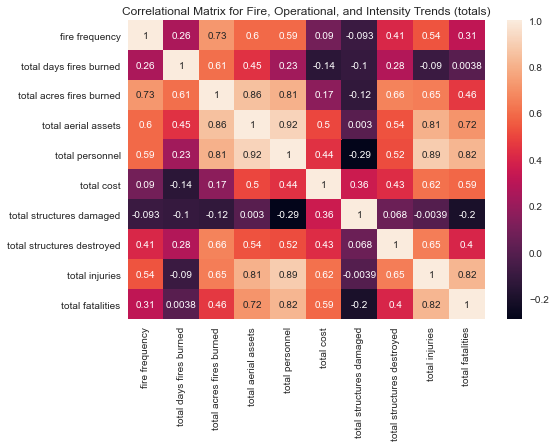

In [35]:
corrMatrix = totals_df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.title("Correlational Matrix for Fire, Operational, and Intensity Trends (totals)")
plt.show()

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


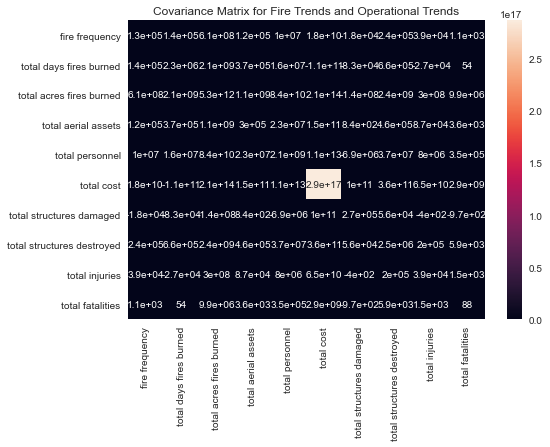

In [36]:
covMatrix = pd.DataFrame.cov(totals_df)
sn.heatmap(covMatrix, annot=True)
plt.title("Covariance Matrix for Fire Trends and Operational Trends")
plt.show()

In [37]:
totals = {"fire frequency": count,
    "total days fires burned": total_days_burn,
    "total acres fires burned": total_acre,
    "total aerial assets": total_aerial,
    "total personnel": total_person,
    "total cost": total_cost,
    "total structures damaged": total_damage,
    "total structures destroyed": total_des,
    "total injuries": total_injury,
    "total fatalities": total_fatality}
averages = {
    "fire frequency": count,
    "average days fire burns": av_days_burn,
    "average acres fire burns": av_acres,
    "average aerial assets per fire": av_aerial,
    "average personnel per fire": av_person,
    "average cost per fire": av_cost,
    "average structures damaged per fire": av_damage,
    "average structures destroyed per fire": av_des,
    "average injuries per fire": av_injury,
    "average fatalities per fire": av_fatality}

totals_scaled = {feature:minmax_scale(totals[feature]) for feature in totals}

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


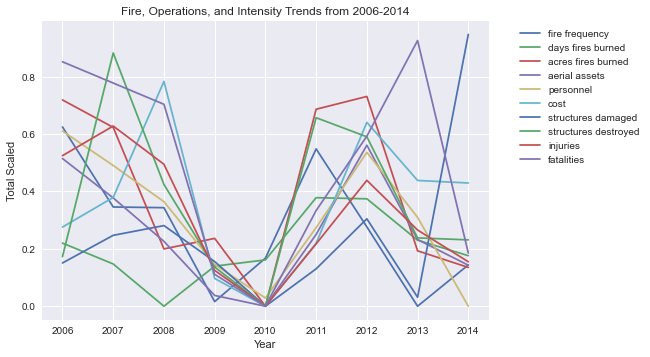

In [38]:
plt.figure()
plt.ylabel("Total Scaled")
plt.xlabel("Year")
plt.title("Fire, Operations, and Intensity Trends from 2006-2014")
for feature in totals_scaled:
    plt.plot(years, totals_scaled[feature], label=feature.replace("total ",""))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## HAZARD METRIC ANALYSIS

In [39]:
document_id_col = "INCIDENT_ID"
extra_cols = ["CY","DISCOVERY_DATE", "START_YEAR", "REPORT_DOY", "DISCOVERY_DOY",
              "TOTAL_PERSONNEL", "TOTAL_AERIAL", "PCT_CONTAINED_COMPLETED"]
list_of_attributes = ["Combined Text"]
file = smart_nlp_path+r"\input data\ICS_filtered_preprocessed_combined_data.csv"

ICS = Topic_Model_plus(document_id_col=document_id_col, extra_cols=extra_cols, list_of_attributes=list_of_attributes, combine_cols=False)
ICS.extract_preprocessed_data(file)
years = ICS.data_df['CY'].unique()
years.sort()
years = [str(float(year)) for year in years]

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Preprocessed data extracted from:  C:\Users\srandrad\smart_nlp\/\input data\ICS_filtered_preprocessed_combined_data.csv


In [40]:
preprocessed_df = ICS.data_df
hazard_file = smart_nlp_path+r"\output data\hazard_interpretation_test.xlsx"

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
time_of_occurence_days, time_of_occurence_pct_contained, frequency, fires, categories, hazards = calc_metrics(hazard_file, years, preprocessed_df, rm_outliers=True)

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\srandrad\Anaconda3\lib\site-packages\openpyxl\compat\numbers.py:41: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numpy.float,
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:04<00:00,  7.14s/it]


### Hazards, metrics, primary results table

In [42]:
table_data = create_primary_results_table(time_of_occurence_days, time_of_occurence_pct_contained, frequency, fires, preprocessed_df, categories, hazards, years, interval=False)
display(pd.DataFrame(table_data))

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Hazard Category,Hazard Name,OTTO days,OTTO days interval,OTTO %,OTTO % interval,Total Frequency,Total Fire Frequency,Average Occurrences per year,Average fires per occurrence
0,Mission,Resource Issues,17.049448022079115+-25.30354983021054,"(16.297036108845987, 17.801859935312244)",41.33218061674009+-33.12169580698387,"(40.36835961074889, 42.29600162273129)",4567,877,97.444444,11.255416
1,Environment,Traffic Hazard,14.09402795425667+-13.381226866076371,"(13.432247461874464, 14.755808446638877)",41.40646551724138+-32.4338548391057,"(39.82735911297945, 42.98557192150331)",1638,354,39.333333,27.884181
2,Environment,Aerial Grounding,11.69438444924406+-10.17845683708391,"(11.037592533481336, 12.351176365006785)",38.81751054852321+-33.35465714553669,"(36.69042479552315, 40.94459630152327)",983,358,39.777778,27.572626


### Metrics Time Series
frequency and OTTO in pct containment

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


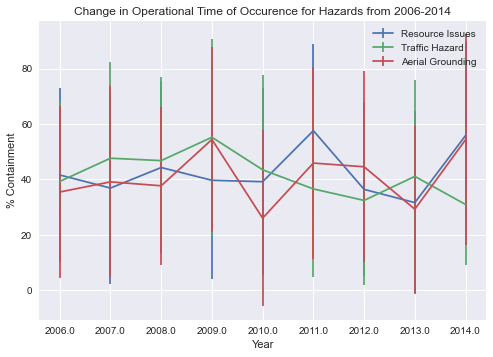

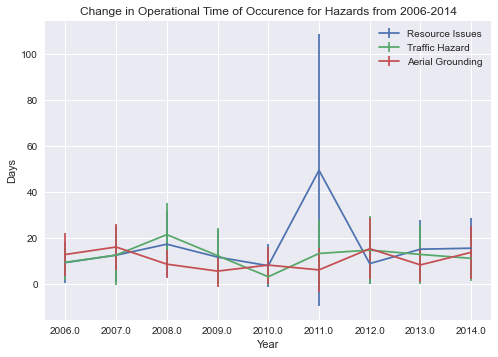

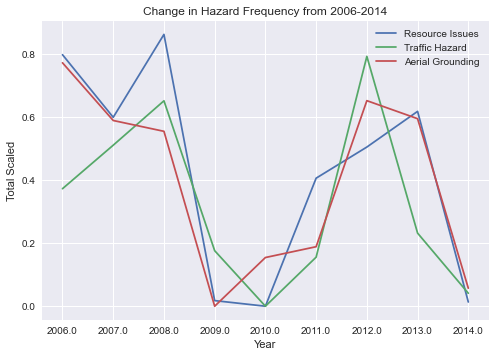

In [43]:
days_averages, days_stddevs, pct_averages, pct_stddevs, frequencies, hazard_freqs_scaled = create_metrics_time_series(time_of_occurence_days, time_of_occurence_pct_contained, frequency, fires, years, combined=True)

### Correlation Matrix

In [44]:
correlation_mat_data = totals_scaled
correlation_mat_total = pd.DataFrame(correlation_mat_data)

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:
corrMatrix =correlation_mat_total.rcorr()
corrMatrix
#sn.heatmap(corrMatrix, annot=True)
#plt.title("Correlational Matrix for Trends in \n Fires, Operations, and Hazard Frequency per year")
#plt.show()

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,fire frequency,total days fires burned,total acres fires burned,total aerial assets,total personnel,total cost,total structures damaged,total structures destroyed,total injuries,total fatalities
fire frequency,-,,*,,,,,,,
total days fires burned,0.259,-,,,,,,,,
total acres fires burned,0.727,0.612,-,**,**,,,,,
total aerial assets,0.596,0.445,0.855,-,***,,,,**,*
total personnel,0.595,0.227,0.807,0.916,-,,,,**,**
total cost,0.09,-0.141,0.168,0.502,0.444,-,,,,
total structures damaged,-0.093,-0.104,-0.12,0.003,-0.29,0.357,-,,,
total structures destroyed,0.408,0.277,0.663,0.535,0.52,0.429,0.068,-,,
total injuries,0.537,-0.09,0.651,0.805,0.89,0.617,-0.004,0.648,-,**
total fatalities,0.315,0.004,0.463,0.717,0.82,0.588,-0.199,0.401,0.823,-


C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


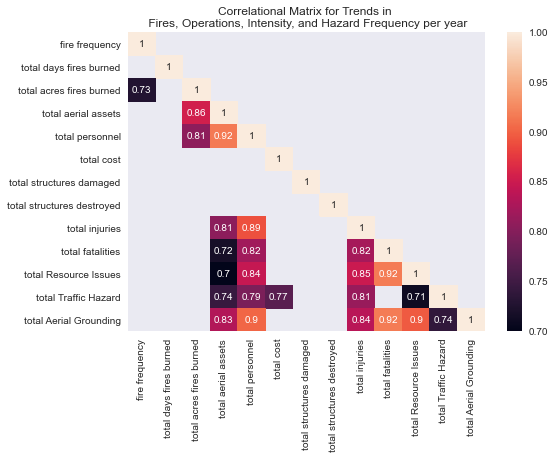

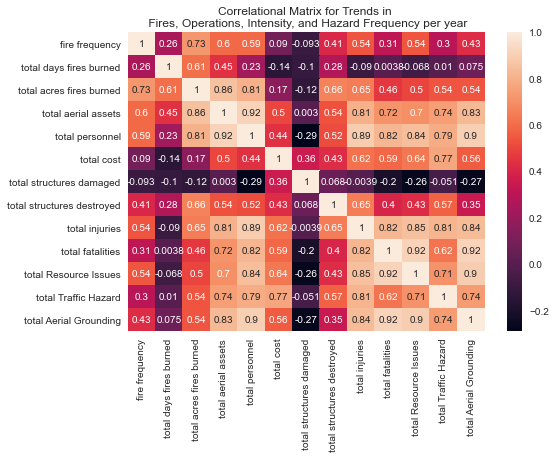

In [46]:
correlation_data = create_correlation_matrix(totals_scaled, hazard_freqs_scaled)

# Multiple regression
typically multiple regression is used as a prediction algorithm, given a certain set of continuous inputs X=(x1,2,...xn), what is the value of continuous variable y? Multiple regression uses a linear combination of X to produce y, and the error in y/goodness of fit indicates how good the predictors are.

The importance of a predictor, xi, is evaluated by removing it from X, and seeing how the goodness of fit/error changes.

### Our goal: 
use regression to determine what the most important predictors are for the frequency of hazards. Since we have a limited number of data points (9) we will not be predicting on unseen data.

#### Inputs/Predictors: 
All operations trends, fire characteristics, and intensity
#### Output/y: 
annual frequency of hazards time series
#### Method:
for each hazard, use its frequency time series:
1. fit linear regression model to the X,y
2. calculate accuracy/error/Beta??
For each Xi:
3. Remove from X
4. repeat model fitting and accuracy
5. record orignal accuracy-removed xi accuracy -> positive large delta means importance, negative delta indicates it should be removed, small delta means little importance

Future goal: use ML to determine whether or not a hazard will occur based on past incident reports

In [47]:
predictors = [p for p in totals_scaled]
results_df, delta_df = multiple_reg_feature_importance(predictors, hazards, correlation_data)
display(results_df, delta_df)

C:\Users\srandrad\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,hazard,R2 for full model,MSE for full model,fire frequency removed score,total days fires burned removed score,total acres fires burned removed score,total aerial assets removed score,total personnel removed score,total cost removed score,total structures damaged removed score,...,total aerial assets removed MSE,total personnel removed MSE,total cost removed MSE,total structures damaged removed MSE,total structures destroyed removed MSE,total injuries removed MSE,total fatalities removed MSE,total Resource Issues removed MSE,total Traffic Hazard removed MSE,total Aerial Grounding removed MSE
0,total Resource Issues,1.0,6.699327e-32,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.093637e-31,5.617062e-32,5.875758e-33,1.286127e-32,1.805727e-32,1.033840e-31,7.299442e-32,2.750903e-32,1.195979e-31,8.649198e-32
1,total Traffic Hazard,1.0,6.776812e-31,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,4.611639e-31,1.273949e-30,1.936630e-32,3.028525e-32,2.128153e-32,1.261324e-31,7.941920e-32,2.226589e-32,1.069373e-31,1.526032e-31
2,total Aerial Grounding,1.0,1.253245e-31,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.235645e-31,1.991264e-31,2.800088e-32,9.443744e-33,1.583676e-32,7.939111e-32,2.983720e-32,1.029303e-32,2.012383e-31,2.564162e-32


,hazard,R2 for full model,MSE for full model,fire frequency removed score,total days fires burned removed score,total acres fires burned removed score,total aerial assets removed score,total personnel removed score,total cost removed score,total structures damaged removed score,...,total aerial assets removed MSE,total personnel removed MSE,total cost removed MSE,total structures damaged removed MSE,total structures destroyed removed MSE,total injuries removed MSE,total fatalities removed MSE,total Resource Issues removed MSE,total Traffic Hazard removed MSE,total Aerial Grounding removed MSE
0,total Resource Issues,1.0,6.699327e-32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-4.237046e-32,1.082266e-32,6.111751e-32,5.413201e-32,4.893601e-32,-3.639071e-32,-6.001144e-33,3.948424e-32,-5.260464e-32,-1.949870e-32
1,total Traffic Hazard,1.0,6.776812e-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.165173e-31,-5.962679e-31,6.583150e-31,6.473960e-31,6.563997e-31,5.515489e-31,5.982621e-31,6.554154e-31,5.707440e-31,5.250781e-31
2,total Aerial Grounding,1.0,1.253245e-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.760086e-33,-7.380190e-32,9.732366e-32,1.158808e-31,1.094878e-31,4.593343e-32,9.548734e-32,1.150315e-31,-7.591374e-32,9.968292e-32
